In [1]:
from kaggle import *

In [2]:
%matplotlib inline

In [3]:
category = "manager_id"
df = train_test[[category, "created", "interest_level"]].copy()

df["low"] = (df["interest_level"] == "low").astype(int)
df["high"] = ((df["interest_level"] == "high") | (df["interest_level"] == "medium")).astype(int)

df["created"] = pd.to_datetime(df["created"]).dt.dayofyear
train_test["created"] = df["created"]

del df["interest_level"]

df.head()

manager_id  created  low  high
listing_id                                                      
7211212     5ba989232d0489da1b5f2c45f6688adc      176    0     1
7150865     7533621a882f71e25173b27e3139d83d      164    1     0
6887163     d9039c43983f6e564b1482b273bd7b01      108    0     1
6888711     1067e078446a7897d2da493d2f741316      109    1     0
6934781     98e13ad4b495b9613cef886d79a6291f      119    1     0

# Compute Prior

In [4]:
interests = ["low","high"]
priors = df[interests].sum() / df[interests].sum().sum()
priors

low     0.694683
high    0.305317
dtype: float64

# Compute mean_code @ created_time

In [5]:
n_data = 10

In [6]:
df = df.sort_values("created").groupby([category, "created"]).agg(sum)[interests].reset_index("created")

In [7]:
temp = df.loc[["0000abd7518b94c35a90d64b56fbf3e6"]].copy().sort_values("created")
temp.head()

created  low  high
manager_id                                          
0000abd7518b94c35a90d64b56fbf3e6      101    0     0
0000abd7518b94c35a90d64b56fbf3e6      106    0     0
0000abd7518b94c35a90d64b56fbf3e6      109    1     0
0000abd7518b94c35a90d64b56fbf3e6      111    0     0
0000abd7518b94c35a90d64b56fbf3e6      115    1     1

In [8]:
temp.loc[:,interests] = temp.loc[:,interests].cumsum(0)
temp.head()

created  low  high
manager_id                                          
0000abd7518b94c35a90d64b56fbf3e6      101    0     0
0000abd7518b94c35a90d64b56fbf3e6      106    0     0
0000abd7518b94c35a90d64b56fbf3e6      109    1     0
0000abd7518b94c35a90d64b56fbf3e6      111    1     0
0000abd7518b94c35a90d64b56fbf3e6      115    2     1

In [9]:
temp[interests] = temp[interests].shift().fillna(0)
temp.head()

created  low  high
manager_id                                          
0000abd7518b94c35a90d64b56fbf3e6      101    0     0
0000abd7518b94c35a90d64b56fbf3e6      106    0     0
0000abd7518b94c35a90d64b56fbf3e6      109    0     0
0000abd7518b94c35a90d64b56fbf3e6      111    1     0
0000abd7518b94c35a90d64b56fbf3e6      115    1     0

In [10]:
temp[interests] = temp[interests] + n_data * priors
temp.head()

created       low      high
manager_id                                                   
0000abd7518b94c35a90d64b56fbf3e6      101  6.946831  3.053169
0000abd7518b94c35a90d64b56fbf3e6      106  6.946831  3.053169
0000abd7518b94c35a90d64b56fbf3e6      109  6.946831  3.053169
0000abd7518b94c35a90d64b56fbf3e6      111  7.946831  3.053169
0000abd7518b94c35a90d64b56fbf3e6      115  7.946831  3.053169

In [11]:
n = temp[interests].sum(1)
temp[interests] = temp[interests].apply(lambda _: _/n)
temp.head()

created       low      high
manager_id                                                   
0000abd7518b94c35a90d64b56fbf3e6      101  0.694683  0.305317
0000abd7518b94c35a90d64b56fbf3e6      106  0.694683  0.305317
0000abd7518b94c35a90d64b56fbf3e6      109  0.694683  0.305317
0000abd7518b94c35a90d64b56fbf3e6      111  0.722439  0.277561
0000abd7518b94c35a90d64b56fbf3e6      115  0.722439  0.277561

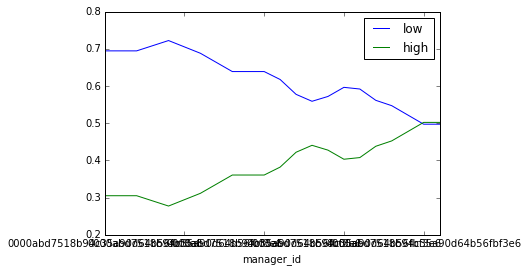

In [13]:
pd.rolling_mean(temp[interests], window=2).fillna(method="bfill").plot()

# Fitting

In [14]:
n_data = 40
nd1 = 1 + n_data 
npriors = n_data * priors 

In [15]:
from tqdm import tqdm

idxs = set(df.index)

for idx in tqdm(idxs):
    temp = df.loc[[idx]].copy()
    
    if len(temp) == 1:
        temp.loc[:,interests] = temp.loc[:,interests].fillna(0) + npriors
        temp[interests] /= nd1
    else:
        temp.loc[:,interests] = temp.loc[:,interests].cumsum(0).shift().fillna(0) + npriors
        n = temp[interests].sum(1)
        temp[interests] = temp.loc[:,interests].apply(lambda _: _/n)
        temp[interests] = pd.rolling_mean(temp[interests], window=2).fillna(method="bfill")
    df.loc[[idx]] = temp.copy()

100%|██████████| 4399/4399 [00:45<00:00, 95.76it/s] 


/usr/lib/python3/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


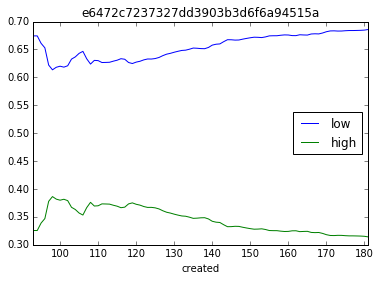

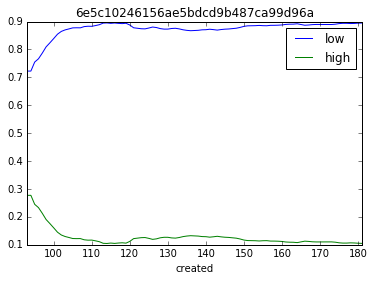

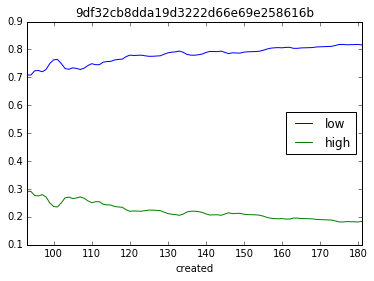

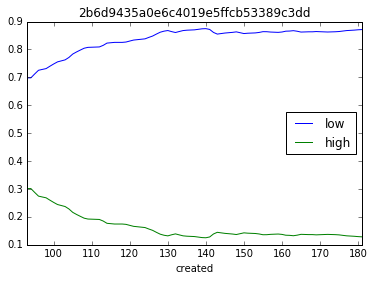

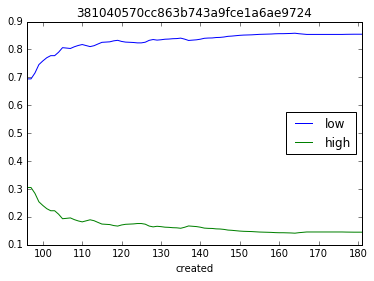

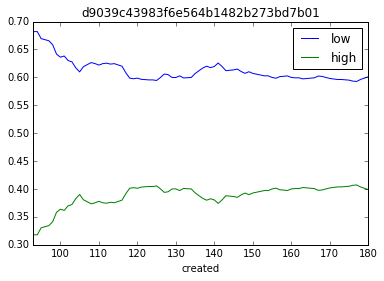

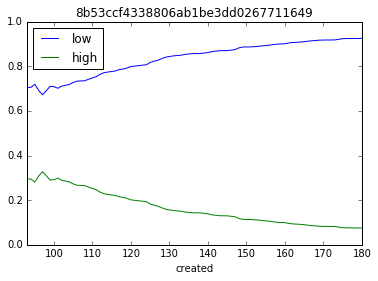

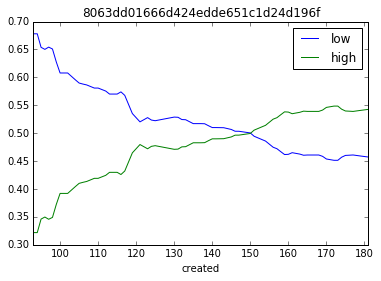

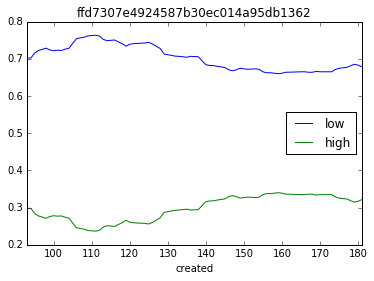

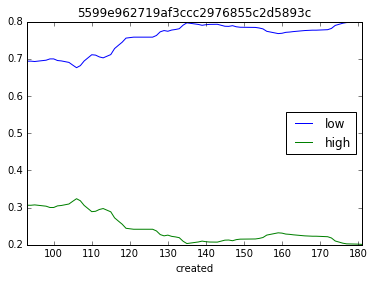

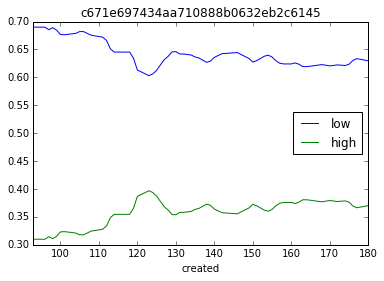

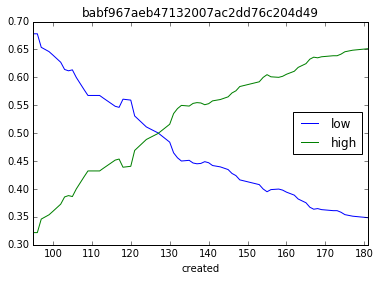

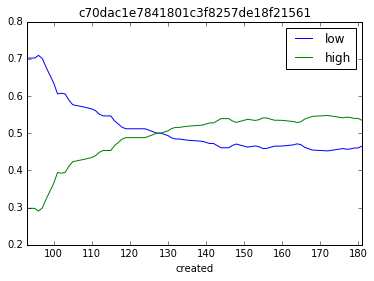

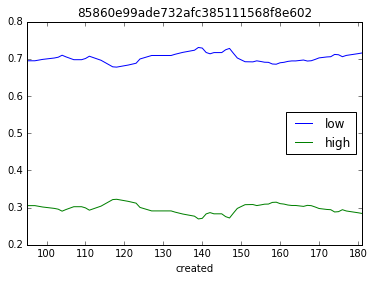

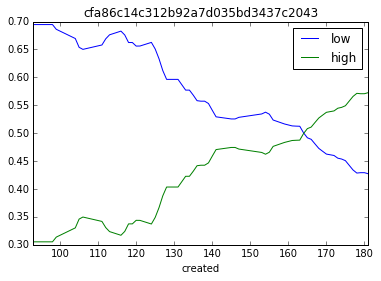

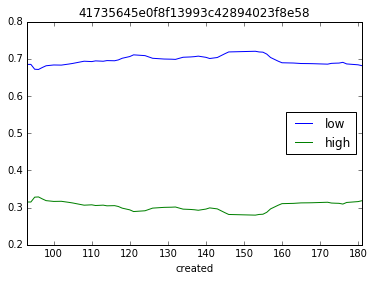

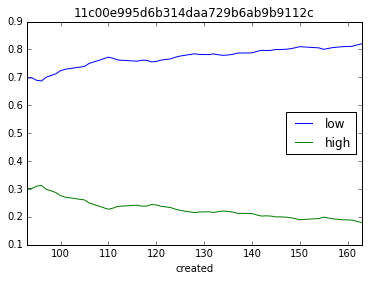

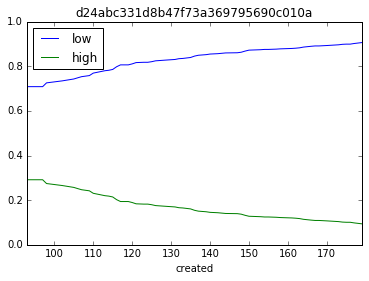

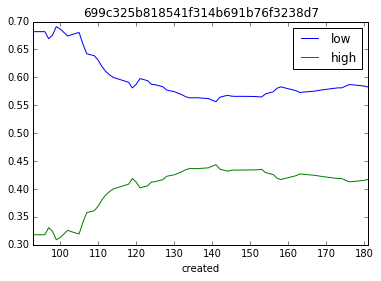

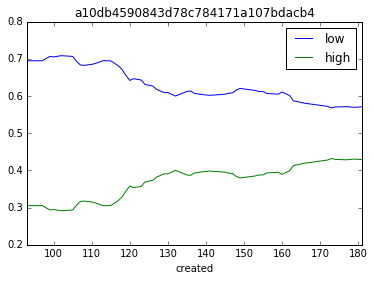

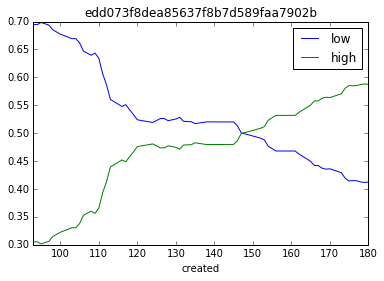

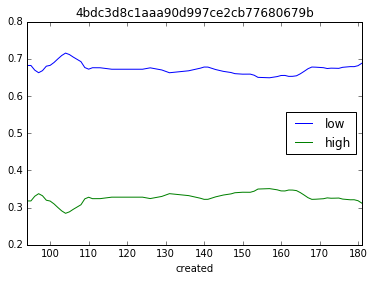

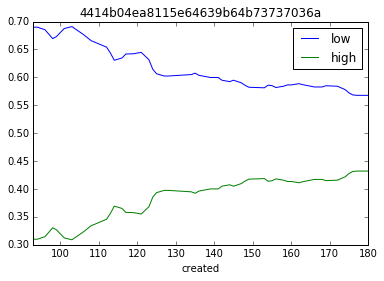

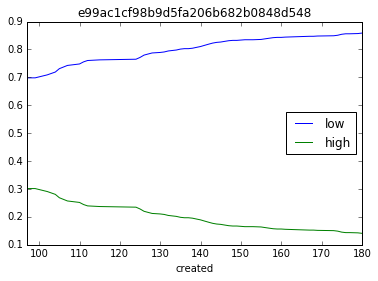

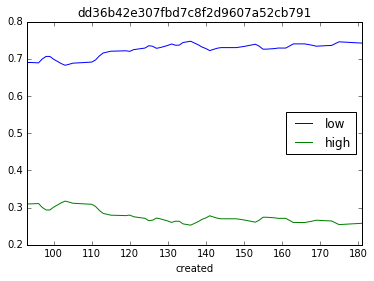

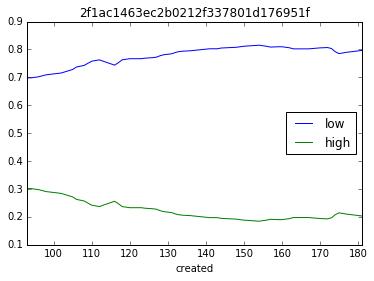

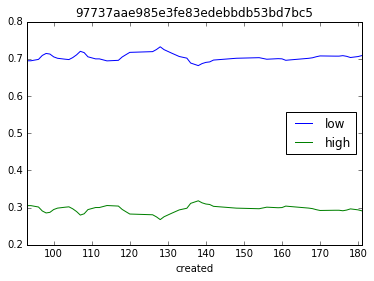

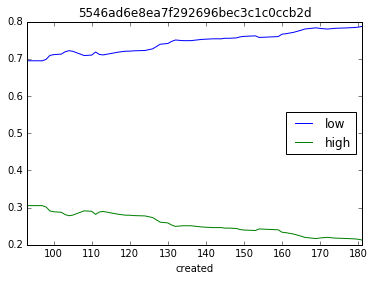

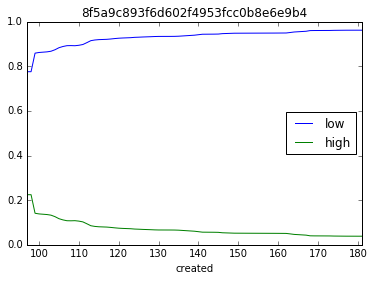

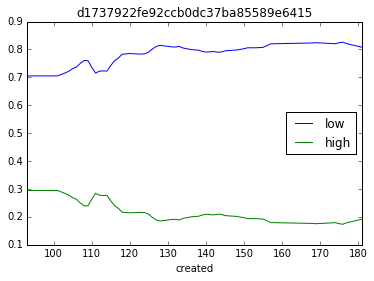

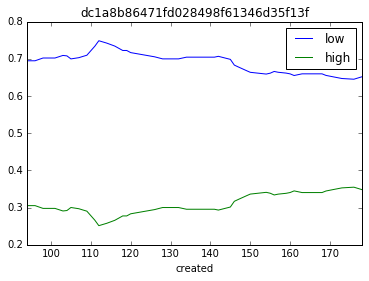

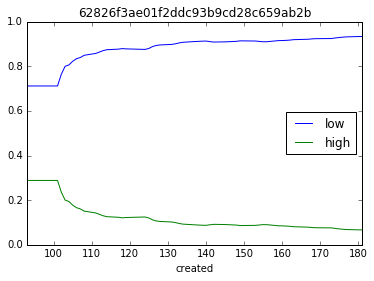

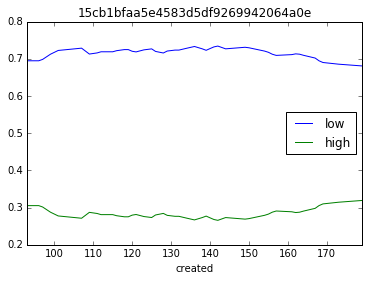

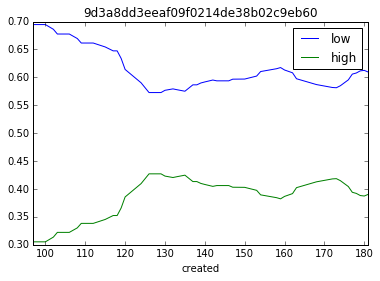

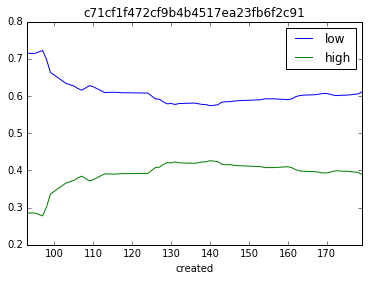

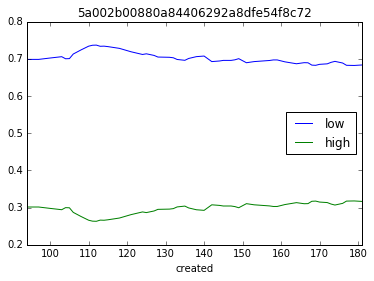

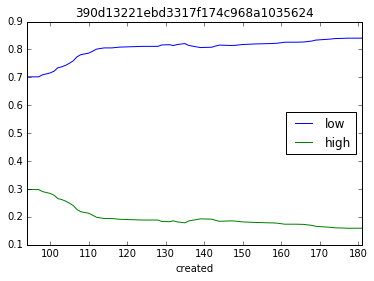

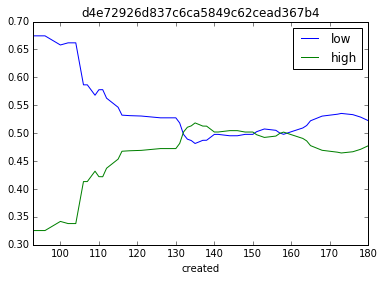

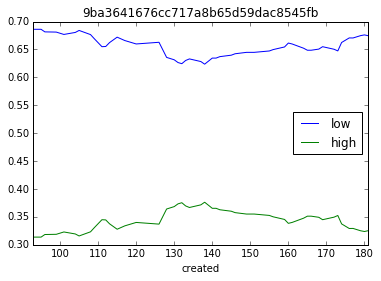

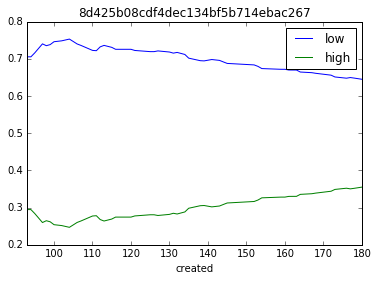

In [16]:
for idx in df.index.value_counts()[:40].index:
    df.loc[[idx]][["created"] + interests].set_index("created").plot(title=idx)

# Join

In [42]:
features = train_test[[category, "created"]].copy()
features["listing_id"] = train_test.index

In [43]:
features = pd.merge(features, df, left_on=[category, "created"], right_on=[category, "created"])

In [44]:
features = features.set_index("listing_id")[["high"]]

In [48]:
features.columns = [category + "_skill"]

In [50]:
features.to_csv("/home/ubuntu/features/f_priors/manager_skill.csv")